
# Analysis of the DiGeorge Syndrome Region in Chromosome 22

This notebook focuses on the analysis of genomic variants within the DiGeorge Syndrome region of chromosome 22.
We will first annotate the VCF file using VEP (Variant Effect Predictor) to enrich our data with functional annotations.
Then, we'll filter the variants to focus on the region of interest and perform various analyses to understand the impact of these variants.


## Step 1: Setup the Environment

We will begin by setting up the necessary environment for Spark and other tools, and then load the VCF file that contains the genomic data.


### Step 1.1: Install Dependencies


In [2]:
!pip install colorama executing beautifulsoup4 requests

In [3]:
# Import necessary libraries
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Install the latest version of PySpark
!pip install pyspark==3.3.2

# Install Glow
!pip install glow.py

# Import necessary modules from PySpark
from pyspark.sql.functions import explode, col
from pyspark.sql import SparkSession

# Import Glow
import glow

# Install Java 8 (if not already installed)
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

### Step 1.2: Configure Spark


In [4]:
# Initiate Spark Session with detailed configuration
spark = SparkSession.builder \
    .appName("1000Genomes") \
    .config("spark.jars.packages",
            "org.apache.hadoop:hadoop-aws:3.3.6,"
            "com.amazonaws:aws-java-sdk-bundle:1.12.565,"
            "io.projectglow:glow-spark3_2.12:1.1.1") \
    .config("spark.driver.memory", "16g") \
    .config("spark.executor.memory", "16g") \
    .getOrCreate()

# Verify Spark session
print("Spark Session created:", spark)
print("Spark Version:", spark.version)
print("Spark App Name:", spark.sparkContext.appName)
print("Spark Master:", spark.sparkContext.master)

Spark Session created: <pyspark.sql.session.SparkSession object at 0x7ee07616ba90>
Spark Version: 3.3.2
Spark App Name: 1000Genomes
Spark Master: local[*]


### Step 1.3: Install VEP


In [5]:
try:
    # Download and install VEP
    !wget https://github.com/Ensembl/ensembl-vep/archive/release/112.zip -O ensembl-vep.zip
    !unzip ensembl-vep.zip
    !mv ensembl-vep-release-112 ensembl-vep
except Exception as e:
    print(f"Error during VEP installation: {e}")

--2024-08-21 13:55:59--  https://github.com/Ensembl/ensembl-vep/archive/release/112.zip
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/Ensembl/ensembl-vep/zip/refs/heads/release/112 [following]
--2024-08-21 13:55:59--  https://codeload.github.com/Ensembl/ensembl-vep/zip/refs/heads/release/112
Resolving codeload.github.com (codeload.github.com)... 20.27.177.114
Connecting to codeload.github.com (codeload.github.com)|20.27.177.114|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘ensembl-vep.zip’

ensembl-vep.zip         [         <=>        ]  60.80M  3.47MB/s    in 18s     

2024-08-21 13:56:17 (3.46 MB/s) - ‘ensembl-vep.zip’ saved [63756818]

Archive:  ensembl-vep.zip
31a3581b84495b617b2f3980da6c6313ca6d238f
replace ensembl-vep-release-112/.github/ISSUE_TEMPLA

In [6]:
# Install Perl and other dependencies
!apt-get install -y perl
!apt-get install -y unzip
!apt-get install -y cpanminus
!cpanm Archive::Zip
!cpanm DBD::SQLite
!cpanm DBD::mysql
!cpanm DBI
# Install BioPerl and other necessary Perl modules
!cpanm Bio::Perl
!cpanm Bio::EnsEMBL::Registry
!cpanm Bio::DB::HTS::Kseq
!cpanm Bio::DB::HTS
!cpanm Bio::DB::BigFile

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
perl is already the newest version (5.34.0-3ubuntu1.3).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unzip is already the newest version (6.0-26ubuntu3.2).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
cpanminus is already the newest version (1.7045-1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.
Archive::Zip is up to date. (1.68)
DBD::SQLite is up to date. (1.74)
DBD::mysql is up to date. (5.008)
DBI is up to date. (1.643)
Bio::Perl is up to date. (1.7.4)
! Finding Bio::EnsEMBL::Registry on cpanmetadb failed.
! Finding Bio::EnsEMBL::Registry () on mirror http://www.cpan.org failed.
! Couldn't find module or a distribution Bio::EnsEMBL::Registr

In [7]:
# Clone and set up Ensembl API dependencies
!git clone https://github.com/Ensembl/ensembl.git
!git clone https://github.com/Ensembl/ensembl-variation.git
!git clone https://github.com/Ensembl/ensembl-funcgen.git
!git clone https://github.com/Ensembl/ensembl-io.git

fatal: destination path 'ensembl' already exists and is not an empty directory.
fatal: destination path 'ensembl-variation' already exists and is not an empty directory.
fatal: destination path 'ensembl-funcgen' already exists and is not an empty directory.
fatal: destination path 'ensembl-io' already exists and is not an empty directory.


In [8]:
%cd ensembl-vep

# Instalar las dependencias de Perl para Ensembl VEP
!cpanm --installdeps .

/content/ensembl-vep
--> Working on .
Configuring /content/ensembl-vep ... OK
<== Installed dependencies for .. Finishing.


In [9]:
# Move the Ensembl modules to the Perl library path
!cp -r /content/ensembl/modules/Bio /usr/local/lib/x86_64-linux-gnu/perl/5.34.0/
!cp -r /content/ensembl-variation/modules/Bio /usr/local/lib/x86_64-linux-gnu/perl/5.34.0/
!cp -r /content/ensembl-funcgen/modules/Bio /usr/local/lib/x86_64-linux-gnu/perl/5.34.0/
!cp -r /content/ensembl-io/modules/Bio /usr/local/lib/x86_64-linux-gnu/perl/5.34.0/

In [10]:
%cd ..
#Set the PERL5LIB environment variable
os.environ['PERL5LIB'] = "/usr/local/lib/x86_64-linux-gnu/perl/5.34.0:/content/ensembl-vep/modules:/content/ensembl/modules:/content/ensembl-variation/modules:/content/ensembl-funcgen/modules:$PERL5LIB"

/content


In [ ]:
cache_dir = "/root/.vep"

if not os.path.exists(cache_dir):
    # Download the VEP cache for human (homo_sapiens) using Perl command directly
    !perl ensembl-vep/INSTALL.pl -a cf -s homo_sapiens -y GRCh38 -c {cache_dir}

    # Path to the downloaded tar.gz file
    tar_gz_file = os.path.join(cache_dir, "homo_sapiens_vep_112_GRCh38.tar.gz")

    # Check if the tar.gz file exists and then extract it
    if os.path.exists(tar_gz_file):
        print("Extracting VEP cache...")
        !tar -xzf {tar_gz_file} -C {cache_dir}/homo_sapiens/
        print("Extraction complete.")
    else:
        print(f"Error: Cache file {tar_gz_file} not found.")
else:
    print("Vep cache already exists.")

 - getting list of available cache files



## Step 2: Load the VCF Data

We will load the VCF file that contains genomic variants and filter it to focus on the DiGeorge Syndrome region in chromosome 22.


In [ ]:
# Define the file paths
vcf_url = "https://ftp-trace.ncbi.nih.gov/1000genomes/ftp/release/20130502/ALL.chr22.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.vcf.gz"
vcf_gz_path = "/content/annotated_output.vcf.gz"
vcf_path = "/content/annotated_output.vcf"

try:
    # Check if the VCF file has already been downloaded
    if not os.path.exists(vcf_path):
        print("VCF file not found, downloading...")
        !wget -q -O {vcf_gz_path} {vcf_url}

        # Unzip VCF file if the download was successful
        if os.path.exists(vcf_gz_path):
            print("Unzipping VCF file...")
            !gunzip {vcf_gz_path}
        else:
            raise FileNotFoundError(f"Downloaded file {vcf_gz_path} was not found.")

    else:
        print("VCF file already exists, skipping download and extraction.")

except Exception as e:
    print(f"An error occurred: {e}")

In [ ]:
# Run VEP with the specified cache directory using Perl command directly
!perl ensembl-vep/vep -i /content/annotated_output.vcf --cache --dir /root/.vep --species homo_sapiens --assembly GRCh38

In [ ]:
# Annotate the dataframe with the vcf data
annotated_vcf_path = "/content/annotated_output.vcf"
vcf_df = spark.read.format("vcf").load(annotated_vcf_path)

vcf_df.show(10)

In [15]:
#Understand the dataset schema
vcf_df.printSchema()

root
 |-- contigName: string (nullable = true)
 |-- start: long (nullable = true)
 |-- end: long (nullable = true)
 |-- names: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- referenceAllele: string (nullable = true)
 |-- alternateAlleles: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- qual: double (nullable = true)
 |-- filters: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- splitFromMultiAllelic: boolean (nullable = true)
 |-- INFO_MEND: integer (nullable = true)
 |-- INFO_AC: array (nullable = true)
 |    |-- element: integer (containsNull = true)
 |-- INFO_CIEND: array (nullable = true)
 |    |-- element: integer (containsNull = true)
 |-- INFO_NS: integer (nullable = true)
 |-- INFO_AFR_AF: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- INFO_VT: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- INFO_AN: integer (nullable = true)
 |-- INF

In [16]:
#Count rows to know the number of variants
vcf_df.count()

1103547

In [17]:
# Count the number of variants by type
variant_counts = vcf_df.groupBy("INFO_VT").count()
variant_counts.show()

+------------+-------+
|     INFO_VT|  count|
+------------+-------+
|[SNP, INDEL]|    871|
|       [SNP]|1059517|
|        [SV]|    782|
|     [INDEL]|  42377|
+------------+-------+



[SNP]: 1,059,517 variants are Single Nucleotide Polymorphisms.

[INDEL]: 42,377 variants are insertions or deletions.

[SV]: 782 are Structural Variants.

[SNP, INDEL]: 871 variants are identified as both SNPs and INDELs, which may indicate a complex variant or multiple annotations.


## Step 3: Annotate the VCF File with VEP

We will use the Variant Effect Predictor (VEP) to annotate the VCF file, adding functional annotations to each variant.


In [ ]:
# Run VEP to annotate the VCF file in offline mode
vcf_file_path = "ALL.chr22.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.vcf.gz"
output_file_path = "annotated_output.vcf"
!cd ensembl-vep && perl vep -i $vcf_file_path -o $output_file_path --assembly GRCh38 --everything --offline

# Load the annotated VCF file into Spark DataFrame
annotated_vcf_path = "/content/annotated_output.vcf"
annotated_vcf_df = spark.read.format("vcf").load(annotated_vcf_path)

# Free up memory by deleting the original large VCF DataFrame if no longer needed
vcf_df = None

# Show the first few rows of the annotated VCF DataFrame
annotated_vcf_df.show(10)


In [ ]:
#Remove compressed files to free memory
# 1. VEP
zip_file_path = 'ensembl-vep.zip'
if os.path.exists(zip_file_path):
    os.remove(zip_file_path)
    print(f"Deleted {zip_file_path} to free up space.")

# 2. VCF
vcf_gz_path = '/content/annotated_output.vcf.gz'
if os.path.exists(vcf_gz_path):
    os.remove(vcf_gz_path)
    print(f"Deleted {vcf_gz_path} to free up space.")

# 3. tar.gz from VEP cache
tar_gz_file = '/root/.vep/homo_sapiens_vep_112_GRCh38.tar.gz'
if os.path.exists(tar_gz_file):
    os.remove(tar_gz_file)
    print(f"Deleted {tar_gz_file} to free up space.")



## Step 4: Filter the Annotated Data and Perform Analysis

Now that we have the annotated data, we will filter it again for the region of interest and then proceed with various analyses, such as counting variant types and analyzing allele frequencies.


In [19]:
# Filter the annotated DataFrame for variants within the DiGeorge Syndrome region on chromosome 22
df_22q11_annotated = annotated_vcf_df.filter(
    (annotated_vcf_df.start >= 18800000) &
    (annotated_vcf_df.start <= 21400000)
)

# Show the first few rows of the filtered annotated DataFrame
df_22q11_annotated.show(10)


+----------+--------+--------+-------------+---------------+----------------+-----+-------+---------------------+---------+-------+----------+-------+-----------+-------+-------+------------------+-----------+----------+-------+------------+-----------+-----------+-------+----------+---------+-----------+--------------+-------+-------+--------+-----------+-----------+--------------+--------+-----------+--------------------+
|contigName|   start|     end|        names|referenceAllele|alternateAlleles| qual|filters|splitFromMultiAllelic|INFO_MEND|INFO_AC|INFO_CIEND|INFO_NS|INFO_AFR_AF|INFO_VT|INFO_AN|INFO_MULTI_ALLELIC|INFO_SAS_AF|INFO_CIPOS|INFO_AA|     INFO_AF|INFO_EAS_AF|INFO_AMR_AF|INFO_DP|INFO_SVLEN|INFO_MLEN|INFO_MEINFO|INFO_IMPRECISE|INFO_CS|INFO_MC|INFO_END|INFO_MSTART|INFO_EUR_AF|INFO_EX_TARGET|INFO_TSD|INFO_SVTYPE|           genotypes|
+----------+--------+--------+-------------+---------------+----------------+-----+-------+---------------------+---------+-------+----------+--

In [ ]:
#Delete variables to save space
del annotated_vcf_df

In [20]:
# Group by variant type and count the occurrences
df_22q11_annotated.groupBy("INFO_VT").count().show()

# Explode the 'alternateAlleles' column to create a row for each alternate allele
df_22q11_annotated = df_22q11_annotated.withColumn("alt", explode(col("alternateAlleles")))

# Explode the 'INFO_AF' column and rename the exploded column to 'AlleleFreq'
df_22q11_annotated = df_22q11_annotated.withColumn("AlleleFreq", explode(col("INFO_AF")))

# Describe allele frequencies
df_22q11_annotated.select("AlleleFreq").describe().show()

+------------+-----+
|     INFO_VT|count|
+------------+-----+
|[SNP, INDEL]|   52|
|       [SNP]|70262|
|        [SV]|   53|
|     [INDEL]| 2766|
+------------+-----+

+-------+-------------------+
|summary|         AlleleFreq|
+-------+-------------------+
|  count|              74493|
|   mean|0.03754631860549758|
| stddev|0.13305905668754203|
|    min|                0.0|
|    max|                1.0|
+-------+-------------------+




## Step 5: Visualize the Allele Frequency Distribution

We will visualize the distribution of allele frequencies within the DiGeorge Syndrome region using a histogram.


In [21]:
# Group by variant type and count the occurrences
df_22q11_annotated.groupBy("INFO_VT").count().show()

+------------+-----+
|     INFO_VT|count|
+------------+-----+
|[SNP, INDEL]|  213|
|       [SNP]|71081|
|        [SV]|   68|
|     [INDEL]| 3131|
+------------+-----+



In [22]:
from pyspark.sql.functions import explode, col

# Explode the 'alternateAlleles' column to create a row for each alternate allele
df_22q11_annotated = df_22q11_annotated.withColumn("alt", explode(col("alternateAlleles")))

In [23]:
# Describe allele frequencies
# Explode the 'INFO_AF' column and rename the exploded column to 'AlleleFreq'
df_22q11_annotated = df_22q11_annotated.withColumn("AlleleFreq", explode(col("INFO_AF")))

#Lets describe the allele frequency
df_22q11_annotated.select("AlleleFreq").describe().show()

+-------+--------------------+
|summary|          AlleleFreq|
+-------+--------------------+
|  count|               81993|
|   mean|0.041034968677512815|
| stddev| 0.13676641935893077|
|    min|                 0.0|
|    max|                 1.0|
+-------+--------------------+



- **Variant Distribution**: The majority of variants in the DiGeorge Syndrome region are SNPs.

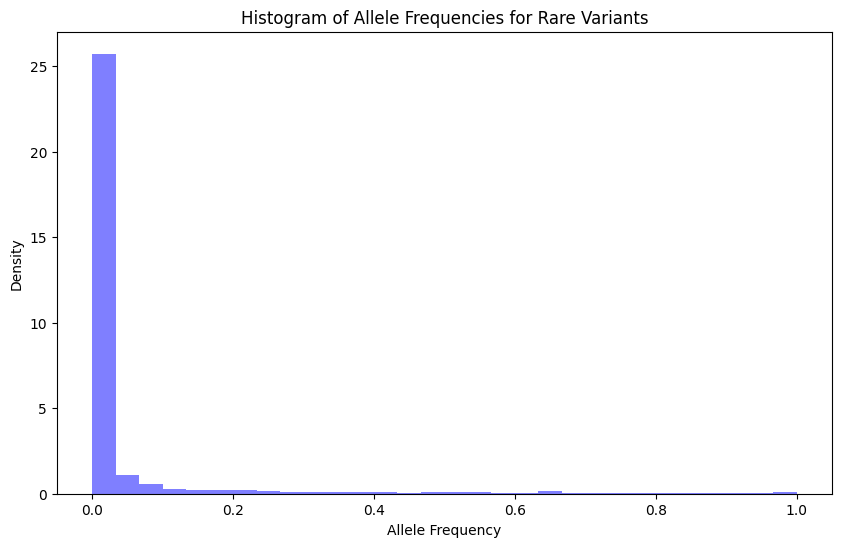

In [24]:
# Convert the DataFrame to a Pandas DataFrame for easier plotting
allele_freqs = df_22q11_annotated.select("AlleleFreq").toPandas()

# Plot a histogram of allele frequencies
plt.figure(figsize=(10, 6))
plt.hist(allele_freqs, bins=30, density=True, alpha=0.5, color='blue')
plt.title('Histogram of Allele Frequencies for Rare Variants')
plt.xlabel('Allele Frequency')
plt.ylabel('Density')
plt.show()

High Peak at Low Frequencies: The tall peak near 0 indicates that the majority of variants have very low allele frequencies. These could represent rare variants that might have more significant impacts on individuals.

Sparse High-Frequency Variants: There are very few variants with higher allele frequencies, suggesting that most of the genetic variation in this region consists of rare variants.

## Step 6: Focus on Rare Variants

In [25]:
# Filter the DataFrame to obtain only rare variants (allele frequency < 0.05).
# This is important because rare variants often have a higher impact on genetic diseases.
rare_variants_df = df_22q11_annotated.filter(df_22q11_annotated["AlleleFreq"] < 0.05)

# Show the first 10 rows of the filtered DataFrame to verify that the filter was applied correctly.
rare_variants_df.show(10)

+----------+--------+--------+-------------+---------------+----------------+-----+-------+---------------------+---------+-------+----------+-------+-----------+-------+-------+------------------+-----------+----------+-------+------------+-----------+-----------+-------+----------+---------+-----------+--------------+-------+-------+--------+-----------+-----------+--------------+--------+-----------+--------------------+---+----------+
|contigName|   start|     end|        names|referenceAllele|alternateAlleles| qual|filters|splitFromMultiAllelic|INFO_MEND|INFO_AC|INFO_CIEND|INFO_NS|INFO_AFR_AF|INFO_VT|INFO_AN|INFO_MULTI_ALLELIC|INFO_SAS_AF|INFO_CIPOS|INFO_AA|     INFO_AF|INFO_EAS_AF|INFO_AMR_AF|INFO_DP|INFO_SVLEN|INFO_MLEN|INFO_MEINFO|INFO_IMPRECISE|INFO_CS|INFO_MC|INFO_END|INFO_MSTART|INFO_EUR_AF|INFO_EX_TARGET|INFO_TSD|INFO_SVTYPE|           genotypes|alt|AlleleFreq|
+----------+--------+--------+-------------+---------------+----------------+-----+-------+---------------------+-

In [27]:
# Check if the consequence type column exists and group by it
rare_variants_df.groupBy("INFO_CS").count().show()

+----------+-----+
|   INFO_CS|count|
+----------+-----+
|      null|71985|
| DUP_uwash|   22|
| DEL_union|   30|
|    DUP_gs|   67|
|  L1_umary|    1|
| ALU_umary|    2|
| SVA_umary|    1|
|NUMT_umich|    1|
+----------+-----+



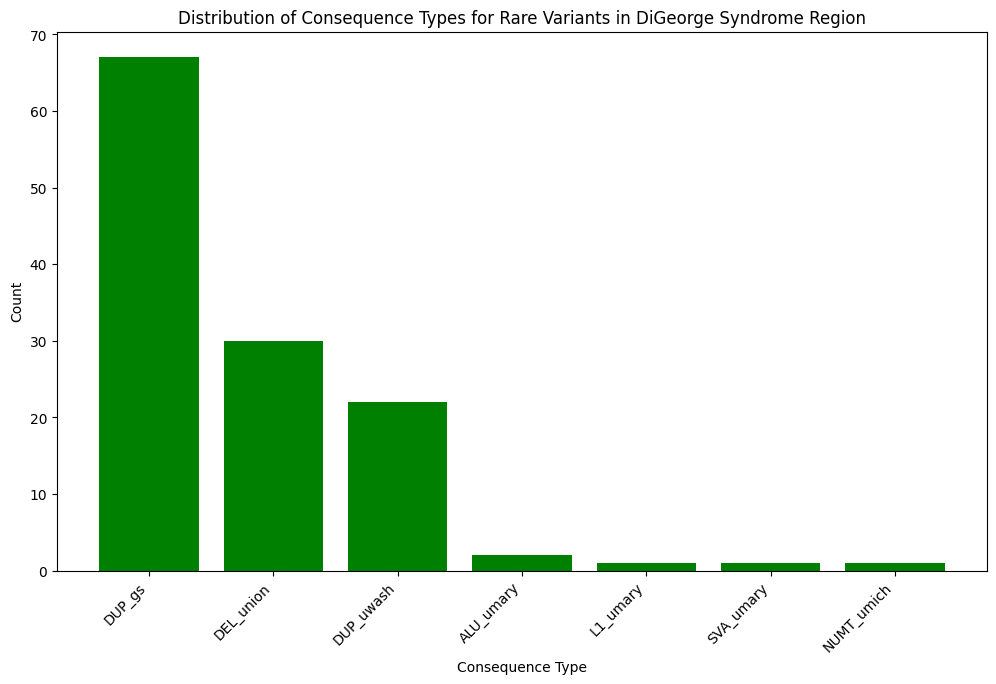

In [28]:
if "INFO_CS" in rare_variants_df.columns:
    consequence_counts = rare_variants_df.groupBy("INFO_CS").count().orderBy("count", ascending=False)
    # Drop rows with missing consequence types before extracting labels
    consequence_counts = consequence_counts.dropna(subset=["INFO_CS"])  # Add this line to drop rows with missing values
    labels, values = zip(*consequence_counts.collect())

    plt.figure(figsize=(12, 7))
    plt.bar(labels, values, color='green')
    plt.title('Distribution of Consequence Types for Rare Variants in DiGeorge Syndrome Region')
    plt.xlabel('Consequence Type')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha="right")
    plt.show()

    #Free memory
    consequence_counts = None
    labels = None
    values = None

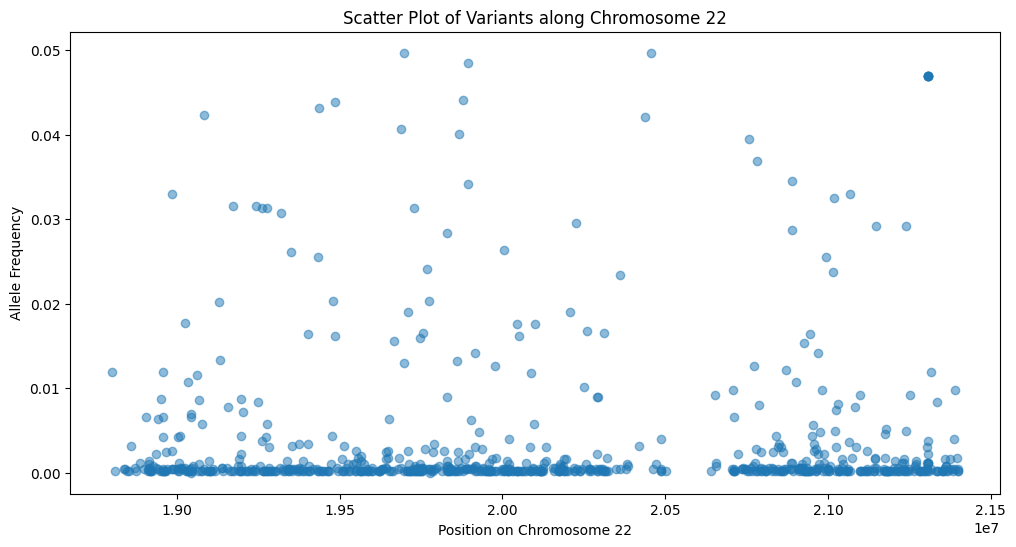

In [31]:
pos, allele_freqs = zip(*rare_variants_df.select("start", "AlleleFreq").sample(False, 0.01).collect())

plt.figure(figsize=(12, 6))
plt.scatter(pos, allele_freqs, alpha=0.5)
plt.title('Scatter Plot of Variants along Chromosome 22')
plt.xlabel('Position on Chromosome 22')
plt.ylabel('Allele Frequency')
plt.show()